In [2]:
# 필요 패키지 설치
! pip install xmltodict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# 폰트 설치
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

In [15]:
# 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
	
# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

In [ ]:
# 런타임 재시작
import os
os.kill(os.getpid(), 9)

**법정동 코드 데이터**

In [1]:
import os
import sys
import urllib.request
import xmltodict
import datetime
import time
import json
import pandas as pd
import ssl
import folium
import seaborn as sns
import matplotlib.pyplot as plt

ssl._create_default_https_context = ssl._create_unverified_context

ServiceKey="5wUibcgyMHJ%2FNqYkVWaxunMQSIZ6tONQ8EJ55I47cV86EUNASc5g3X9dF1Bzr5SqqfprwYvMEnhnHlZ8hwpctQ%3D%3D"

df_area = pd.read_excel(io='/content/drive/MyDrive/Colab Notebooks/법정동코드.xlsx', header=None, names=['zcode','zcode_name','zscode','zscode_name'])

print(df_area)

     zcode zcode_name  zscode zscode_name
0       11      서울특별시   11110         종로구
1       11      서울특별시   11140          중구
2       11      서울특별시   11170         용산구
3       11      서울특별시   11200         성동구
4       11      서울특별시   11215         광진구
..     ...        ...     ...         ...
224     48       경상남도   48870         함양군
225     48       경상남도   48880         거창군
226     48       경상남도   48890         합천군
227     50        제주도   50110         제주시
228     50        제주도   50130        서귀포시

[229 rows x 4 columns]


**API를 통해 특정 지역 데이터 가져오는 함수**

In [12]:
def getData(zcode, zscode):
  total_data = []
  service_url = 'https://apis.data.go.kr/B552584/EvCharger/getChargerInfo'
  parameters = '?serviceKey=' + ServiceKey   #인증키
  parameters += '&pageNo=1&numOfRows=9999&zcode=' + zcode
  parameters += '&zscode=' + zscode
  url = service_url + parameters

  response = urllib.request.urlopen(url)
  results = response.read().decode('utf-8')
  results_to_json = xmltodict.parse(results)
  data = json.loads(json.dumps(results_to_json))
  total_data.extend(data['response']['body']['items']['item'])

  df_total_temp = pd.DataFrame(total_data)
  df_total = df_total_temp

  return df_total

**전국 분포 현황 출력을 위한 전국 데이터 가져오는 함수**

In [4]:
def getTotalData():
  total_data = []
  area_array_temp = df_area.drop_duplicates(['zcode'])
  area_array = list(map(str, area_array_temp['zcode'].to_numpy()))

  for z in area_array:
    service_url = 'https://apis.data.go.kr/B552584/EvCharger/getChargerInfo'
    parameters = '?serviceKey=' + ServiceKey   #인증키
    parameters += '&pageNo=1&numOfRows=9999&zcode=' + z

    detail_area_array_temp = df_area[df_area['zcode'] == int(z)]
    detail_area_array = list(map(str, detail_area_array_temp['zscode'].to_numpy()))

    for zs in detail_area_array:
      parameters += '&zscode=' + zs
      url = service_url + parameters

      response = urllib.request.urlopen(url)
      results = response.read().decode('utf-8')
      results_to_json = xmltodict.parse(results)
      data = json.loads(json.dumps(results_to_json))
      total_data.extend(data['response']['body']['items']['item'])
      parameters = parameters[:-13]
      
  df_total = pd.DataFrame(total_data)
  df_total.to_csv('/content/drive/MyDrive/Colab Notebooks/total_data.csv')

print(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/total_data.csv').head())

        Unnamed: 0        statNm    statId  chgerId  chgerType  \
0                0          태화빌딩  ME174039        1          6   
1                1  한국예술종합학교(종로)  ME174040        1          6   
2                2      부암동 주민센터  ME18B169        1          6   
3                3       서울역사박물관  ME18B288       11          4   
4                4       서울역사박물관  ME18B288       12          4   
...            ...           ...       ...      ...        ...   
174842      174842        제주블루앤씨  TDO00071        1          2   
174843      174843         카페이피엘  TDO10001        1          6   
174844      174844         제주올레돔  TDO10004        1          5   
174845      174845      서귀포시산림조합  TDO10005        1          5   
174846      174846     대정맑은해수사우나  TDO10006        1          5   

                                 addr   location        lat         lng  \
0                  서울특별시 종로구 인사동5길 29        NaN  37.571815  126.985044   
1                  서울특별시 종로구 창경궁로 215        NaN  37.5824

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**지도 Marker 찍는 함수**

In [13]:
def marker(data, color, icon, map):
  for name, addr, lat, lng, free, chtype in zip(data.statNm, data.addr, data.lat, data.lng, data.parkingFree, data.chgerType):
    free_val = ''
    if free == 'Y':
      free_val = '무료'
    else:
      free_val = '유료'

    chtype = int(chtype)
    ch_array = ['DC 차데모', 'AC 완속', 'DC 차데모 + AC3 상', 'DC 콤보', 'DC 차데모 + DC 콤보', 'DC 차데모 + AC3 상 + DC 콤보', 'AC3 상', 'H2']
    charger_type = ch_array[chtype - 1]

    html = f'''
            <h2>{name}</h2>
            <p>주소 : {addr}</p>
            <p>주차료 : {free_val}</p>
            <p>충전기 타입 : {charger_type}</p>
            '''
    iframe = folium.IFrame(html, width=300, height=200)
    popup = folium.Popup(iframe, max_width=400)
    folium.Marker([lat, lng], popup=popup, tooltip=name, icon=folium.Icon(color, icon=icon, prefix='fa')).add_to(map)

지역 코드 및 지역 이름 데이터
     zcode zcode_name
0       11      서울특별시
25      26      부산광역시
41      27      대구광역시
49      28      인천광역시
59      29      광주광역시
64      30      대전광역시
69      31      울산광역시
74      36        세종시
75      41        경기도
106     42        강원도
124     43       충청북도
135     44       충청남도
150     45       전라북도
164     46       전라남도
186     47       경상북도
209     48       경상남도
227     50        제주도

데이터에서 추출한 지역 이름 배열
['서울특별시' '부산광역시' '대구광역시' '인천광역시' '광주광역시' '대전광역시' '울산광역시' '세종시' '경기도' '강원도'
 '충청북도' '충청남도' '전라북도' '전라남도' '경상북도' '경상남도' '제주도']

지역 목록 : 서울특별시 부산광역시 대구광역시 인천광역시 광주광역시 대전광역시 울산광역시 세종시 경기도 강원도 충청북도 충청남도 전라북도 전라남도 경상북도 경상남도 제주도 지역 : 서울특별시

zcode : 11

서울특별시의 상세 지역 코드 및 상세 지역 이름 데이터
    zcode zcode_name  zscode zscode_name
0      11      서울특별시   11110         종로구
1      11      서울특별시   11140          중구
2      11      서울특별시   11170         용산구
3      11      서울특별시   11200         성동구
4      11      서울특별시   11215         광진구
5      11      서울특별시   11230        동대문구
6 

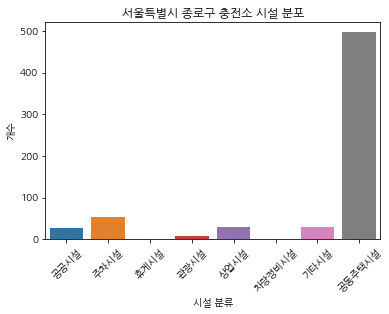

In [20]:
def main():
  # 지역 코드
  area_array_temp = df_area.drop_duplicates(['zcode']).iloc[:,[0,1]]
  area_array = area_array_temp['zcode_name'].to_numpy()

  print('지역 코드 및 지역 이름 데이터')
  print(area_array_temp)
  print()
  print('데이터에서 추출한 지역 이름 배열')
  print(area_array)
  print()

  print('지역 목록 :', end=' ')
  for a in area_array:
    print(a, end=' ')
  zcode_temp = input('지역 : ')
  if zcode_temp not in area_array:
    print('올바른 지역이 아닙니다.')
    return
  zcode = str(area_array_temp[area_array_temp['zcode_name'] == zcode_temp].iat[0,0])

  print()
  print('zcode : ' + zcode)
  print()

  if zcode_temp == '세종시':
    zscode = '36110'
    zscode_temp = ''
  else:
    # 상세 지역 코드
    detail_area_array_temp = df_area[df_area['zcode_name'] == zcode_temp]
    detail_area_array = detail_area_array_temp['zscode_name'].to_numpy()

    print('{0}의 상세 지역 코드 및 상세 지역 이름 데이터'.format(zcode_temp))
    print(detail_area_array_temp)
    print()
    print('데이터에서 추출한 {0}의 상세 지역 이름 배열'.format(zcode_temp))
    print(detail_area_array)
    print()
  
    print(zcode_temp + ' 상세 지역 목록 :', end=' ')
    for a in detail_area_array:
      print(a, end=' ')
    zscode_temp = input('상세 지역 : ')
    if zscode_temp not in detail_area_array:
      print('올바른 상세 지역이 아닙니다.')
      return
    zscode = str(detail_area_array_temp[detail_area_array_temp['zscode_name'] == zscode_temp].iat[0,2])

  print()
  print('zscode : ' + zscode)
  print()

  # 데이터 불러오기
  data = getData(zcode, zscode)

  print('불러온 데이터')
  print(data)
  
  data_avail = data[data['stat'] == '2']
  data_using = data[data['stat'] == '3']

  smap = folium.Map(location=[37.4493812, 126.6573386], zoom_start=10, tiles='Stamen Terrain')

  geo='/content/drive/MyDrive/Colab Notebooks/GeoJSON/' + zcode_temp + '.json'
  total_data_temp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/total_data.csv', low_memory=False)
  total_data = total_data_temp[total_data_temp['zcode'] == int(zcode)].groupby('zscode', as_index=False).count()
  total_data['zscode'] = total_data['zscode'].astype(str)

  marker(data_avail, 'green', 'check', smap)
  marker(data_using, 'red', 'times', smap)
  folium.Choropleth(geo_data=geo, data=total_data, columns=['zscode','lat'], fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.3,
                    threshold_scale=[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000], key_on='feature.properties.COL_ADM_SE').add_to(smap)
  
  smap.save('/content/' + zcode_temp + '_' + zscode_temp + '_충전소_현황.html')
  print('{0} {1} 충전소 현황이 완성되었습니다.'.format(zcode_temp, zscode_temp))
  print()
  ax = sns.countplot(data=data, x='kind', order=['A0','B0','C0','D0','E0','F0','G0','H0'])
  ax.set_title('{0} {1} 충전소 시설 분포'.format(zcode_temp, zscode_temp))
  ax.set_xlabel('시설 분류')
  ax.set_ylabel('개수')
  ax.set_xticklabels(labels=['공공시설', '주차시설', '휴게시설', '관광시설', '상업시설', '차량정비시설', '기타시설', '공동주택시설'], rotation=45)
  

if __name__ == '__main__':
  main()